In this worked notebook file,the Support Vector Regression algorithm is applied to a dataset called steel.

The dependent variable that we are trying to predict is tensile_strength, which is a numerical value

In [2]:
import pandas as pd

# details for steel dataset
independent_cols = ["normalising_temperature", "tempering_temperature", "percent_silicon", "percent_chromium", "percent_copper", "percent_nickel", "percent_sulphur", "percent_carbon", "percent_manganese"]

dependent_col = "tensile_strength"

# Here we load our dataset in from file using the pandas library
df = pd.read_csv("steel.csv")
print("Data Shape:\n", df.shape)
print("Data Description:\n", df.describe())

Data Shape:
 (553, 10)
Data Description:
        normalising_temperature  tempering_temperature  percent_silicon  \
count               553.000000             553.000000       553.000000   
mean                478.205222             752.124774         0.063890   
std                 162.317845             259.220817         0.080655   
min                 178.500000             225.000000         0.000000   
25%                 382.987500             550.000000         0.000000   
50%                 465.850000             900.000000         0.000000   
75%                 570.500000             900.000000         0.129800   
max                 945.000000             950.000000         0.359400   

       percent_chromium  percent_copper  percent_nickel  percent_sulphur  \
count        553.000000      553.000000      553.000000       553.000000   
mean           1.277492        0.784018        0.972592         0.059302   
std            0.260280        0.068589        0.074270        

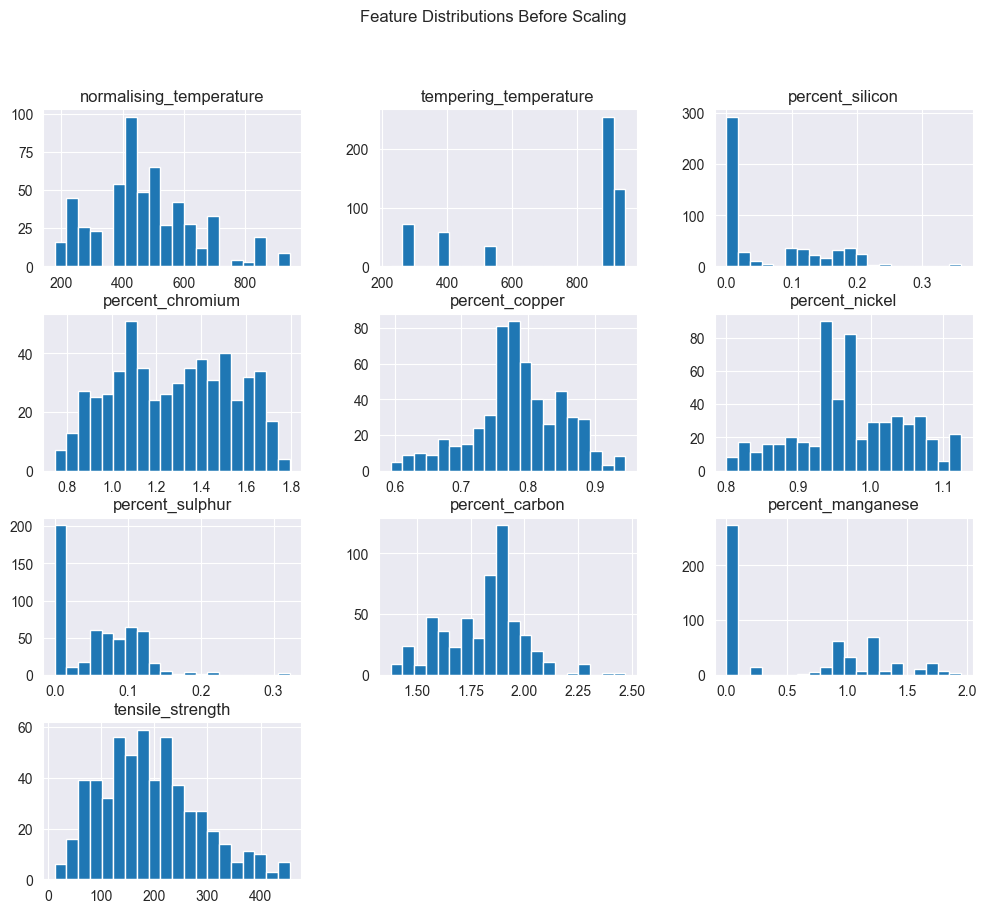

In [4]:
import matplotlib.pyplot as plt

df.hist(bins=20, figsize=(12, 10))
plt.suptitle("Feature Distributions Before Scaling")
plt.show()


Looking at Feature Correlation.

The corelation matrix with heatmaps shows pairwise correlations coefficients- which shows how strongly features are related to eachother and the target.

The correlation matrix with scatterplots visualizes these relationships further by plotting scatterplots for each pair of features along with histograms on the diagonal to show individual feature distributions.

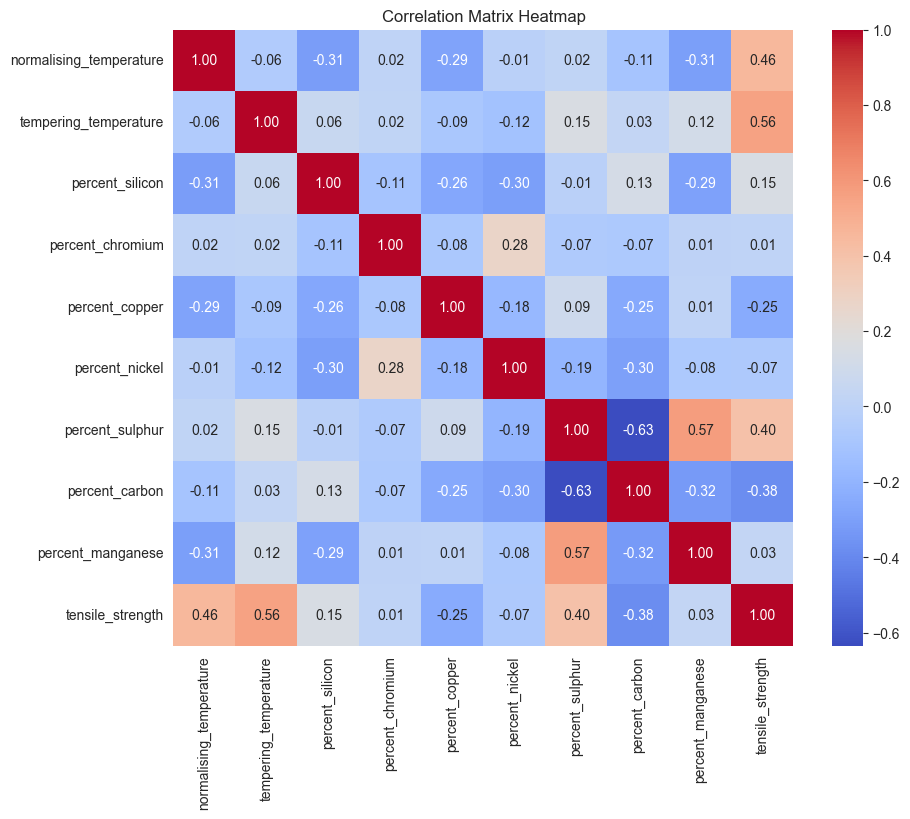

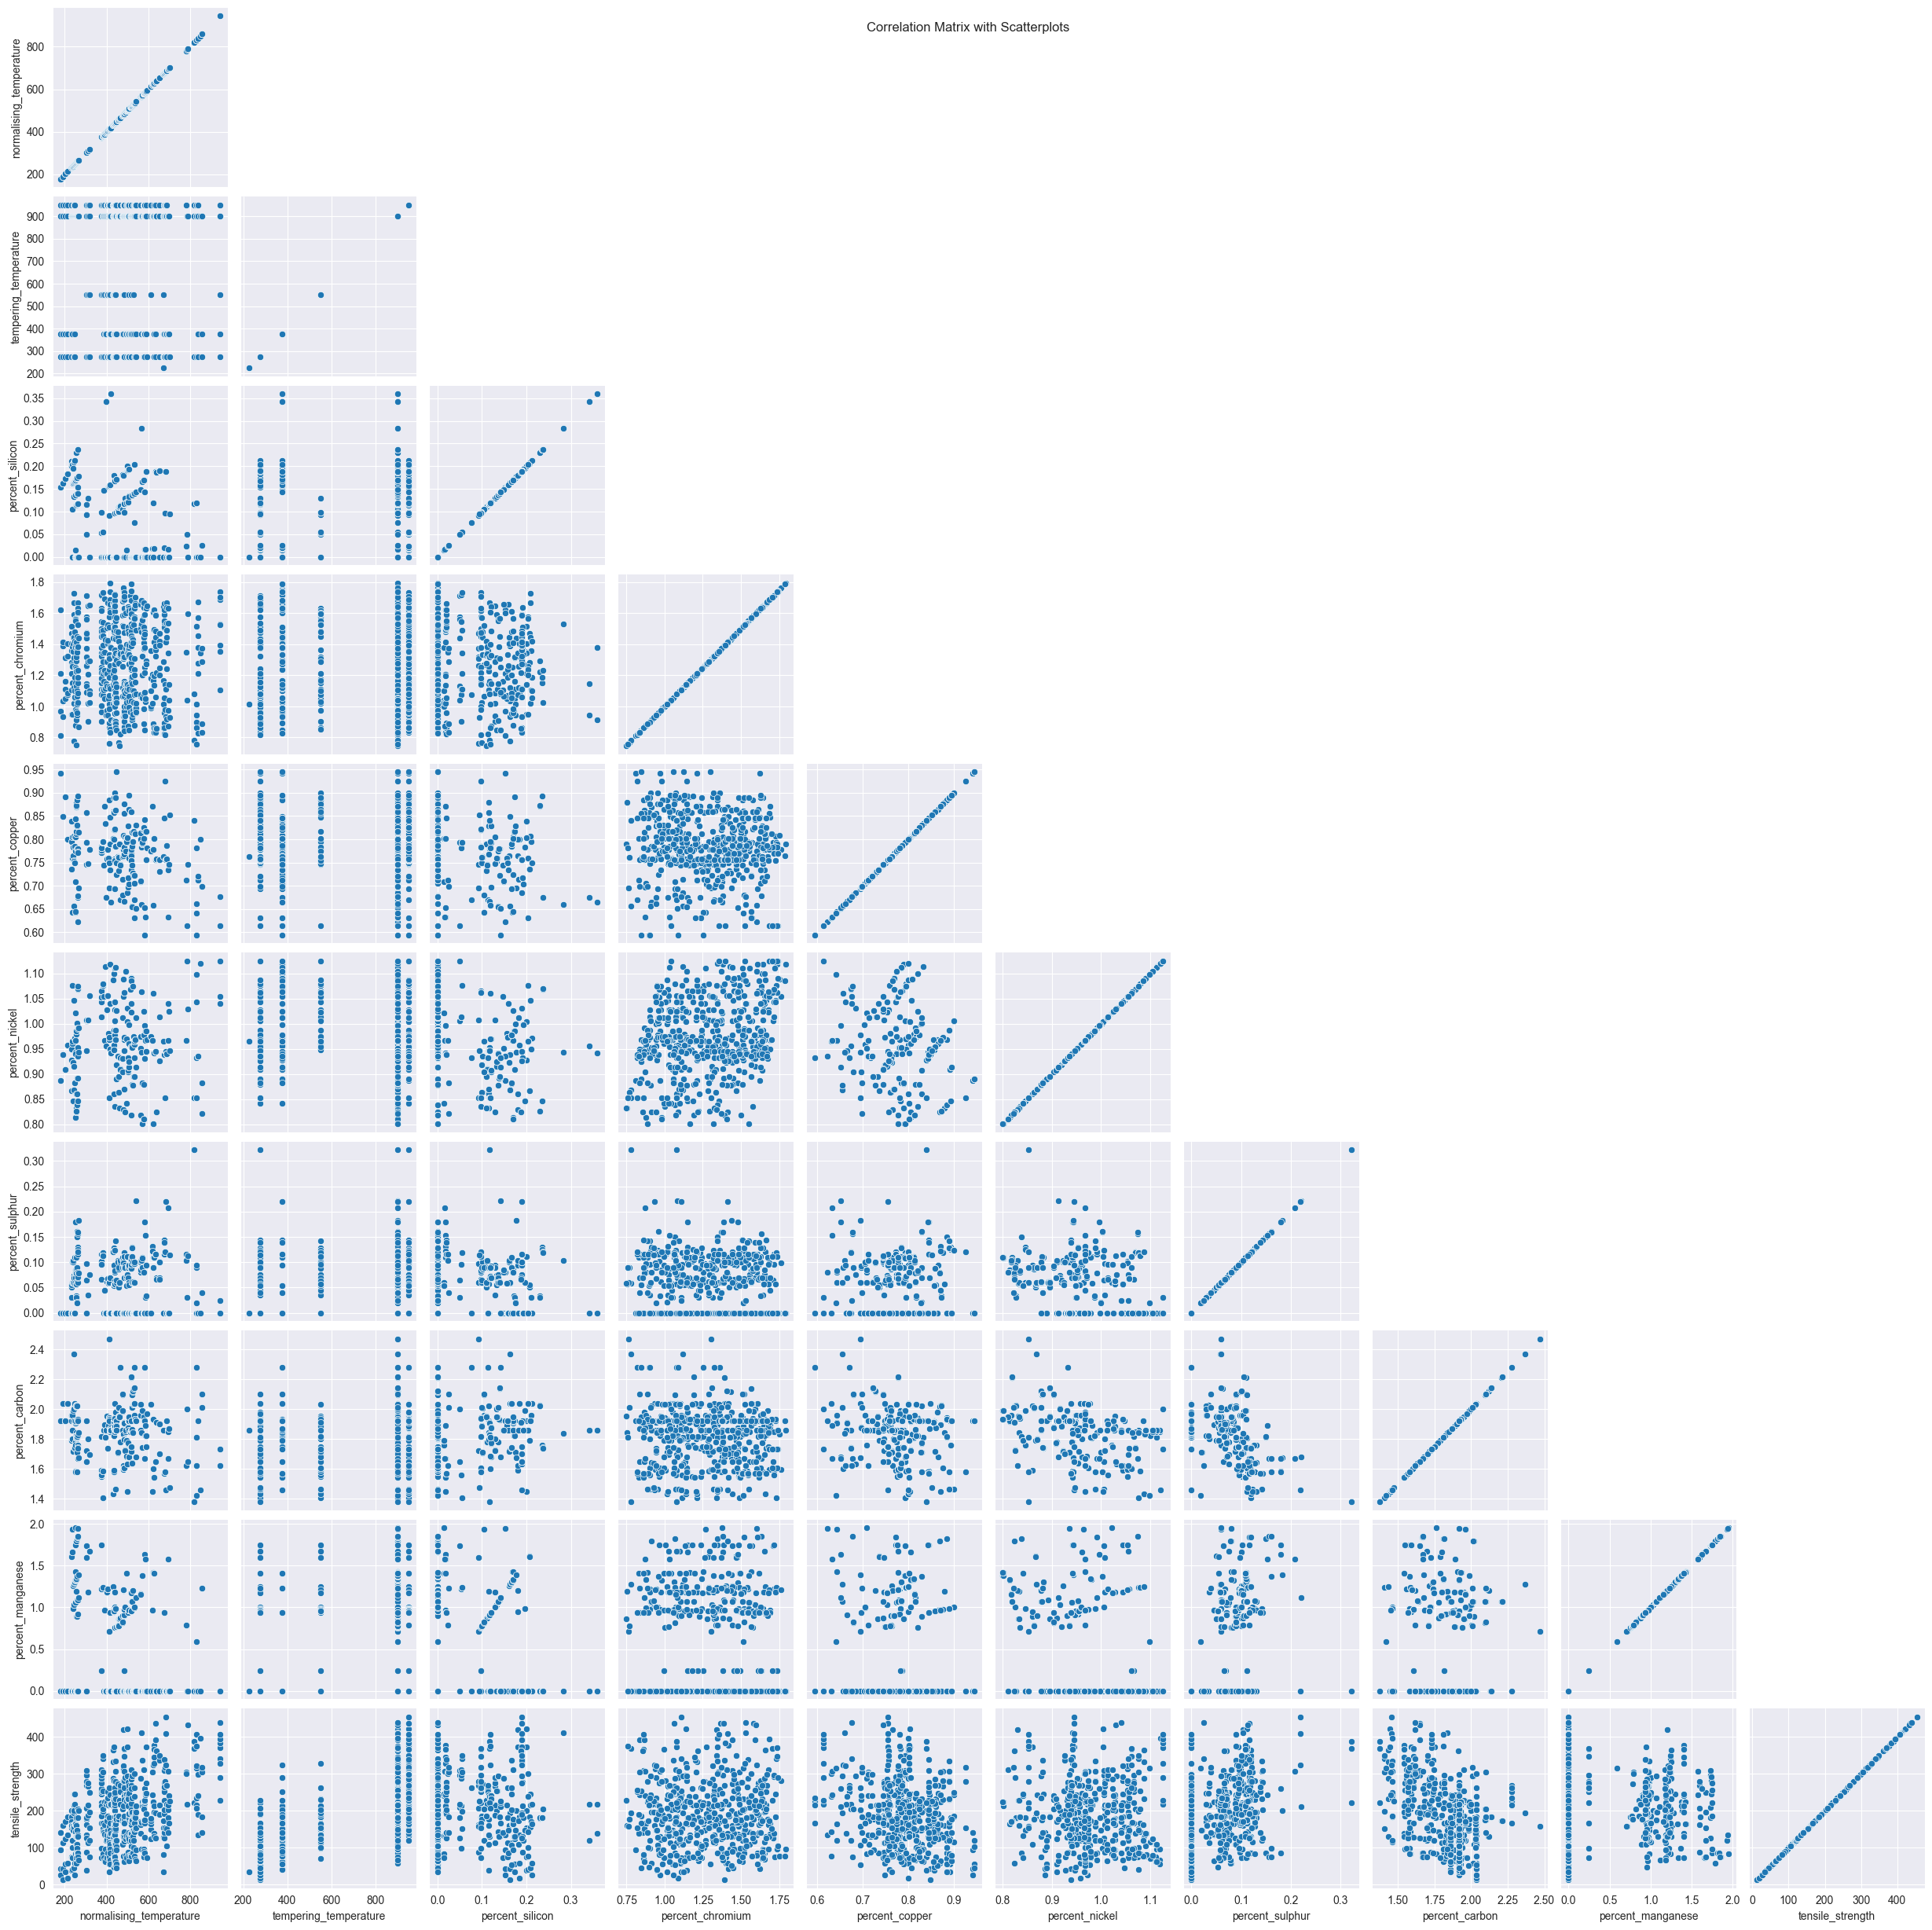

In [6]:
import seaborn as sns

corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix Heatmap")

sns.pairplot(df, diag_kind=None, corner=True)
plt.suptitle("Correlation Matrix with Scatterplots")

plt.show()

Now we investigate features with low correlation to the target variable and remove them if necessary.

Features with weak correlation to target (< 0.3):
percent_copper      -0.247777
percent_nickel      -0.072496
percent_chromium     0.012675
percent_manganese    0.033437
percent_silicon      0.146153
Name: tensile_strength, dtype: float64


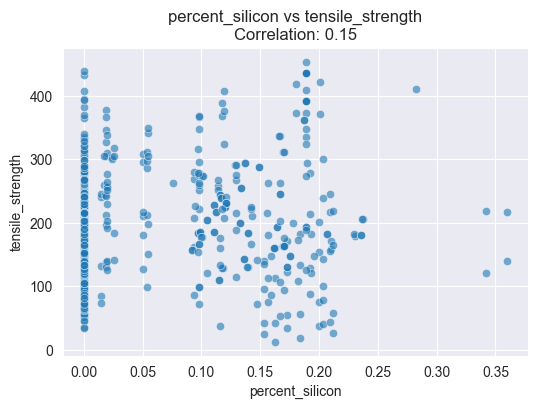

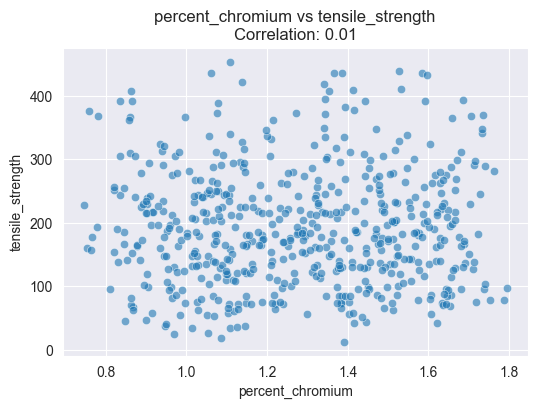

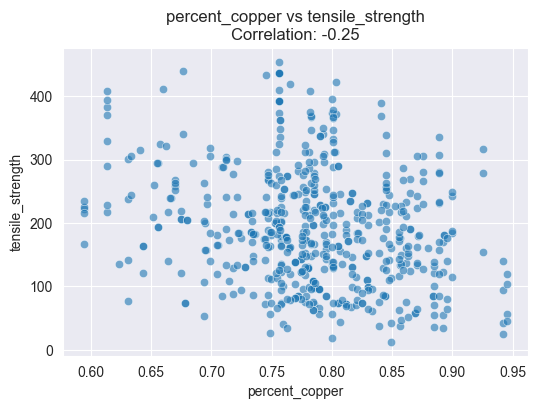

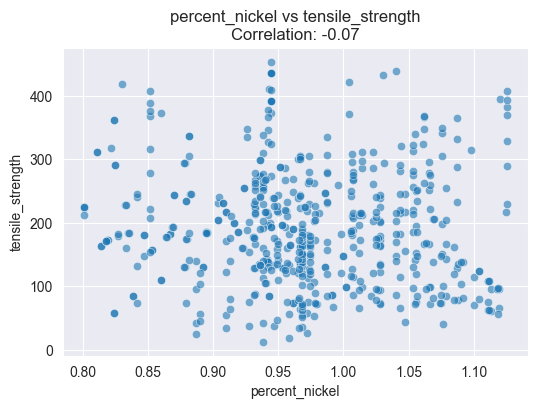

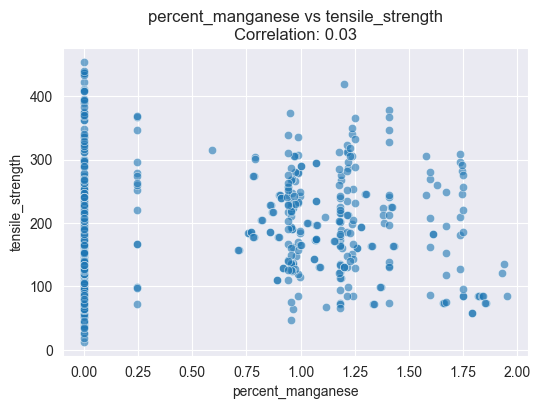

In [13]:
#compute correlations to the target variable
correlations = df.corr(numeric_only=True)[dependent_col].drop(dependent_col)  # drop self-correlation

#threshold for correlation strength
threshold = 0.3

#identify features with correlation below the threshold (both positive and negative)
weak_corr_features = correlations[abs(correlations) < threshold]

print("Features with weak correlation to target (< 0.3):")
print(weak_corr_features.sort_values())

# Visualize each weakly correlated feature vs target using scatterplots
for feature in weak_corr_features.index:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[feature], y=df[dependent_col], alpha=0.6)
    plt.title(f"{feature} vs {dependent_col}\nCorrelation: {correlations[feature]:.2f}")
    plt.xlabel(feature)
    plt.ylabel(dependent_col)
    plt.show()

In [11]:
df_reduced = df.drop(columns=weak_corr_features.index.tolist())

print("\nRemaining features:\n")
print(df_reduced.columns.tolist())


Remaining features:

['normalising_temperature', 'tempering_temperature', 'percent_sulphur', 'percent_carbon', 'tensile_strength']


In [14]:
#prepare features (X) and target (Y)
X = df_reduced.drop(columns=[dependent_col])
y = df_reduced[dependent_col]
print("Features:\n", X.head())
print("Target:\n", y.head())

Features:
    normalising_temperature  tempering_temperature  percent_sulphur  \
0                  178.500                    275              0.0   
1                  178.500                    950              0.0   
2                  178.500                    375              0.0   
3                  178.500                    900              0.0   
4                  189.525                    900              0.0   

   percent_carbon  
0           1.920  
1           1.920  
2           1.920  
3           1.920  
4           2.035  
Target:
 0     25.107613
1    140.035334
2     42.217650
3     95.015309
4    113.266773
Name: tensile_strength, dtype: float64


In [15]:
from sklearn.model_selection import train_test_split
# Split data into training and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(442, 4)
(442,)
(111, 4)
(111,)


Scale the data

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("First 5 rows of X_train_scaled:\n", X_train_scaled[:5])  # first 5 rows
print("First 5 rows of X_test_scaled:\n", X_test_scaled[:5])

First 5 rows of X_train_scaled:
 [[-1.59465788  0.58010022 -1.09423562  0.55903696]
 [ 0.13343795  0.58010022  0.5930015   0.33821443]
 [ 1.2555781   0.58010022  1.51723249 -1.37316017]
 [ 0.02122394  0.77144672 -1.09423562  0.50383133]
 [ 1.10969988  0.58010022  0.21805992  0.4486257 ]]
First 5 rows of X_test_scaled:
 [[ 2.97245254  0.58010022 -1.09423562 -0.48987005]
 [-1.3937948   0.58010022  1.08042555 -0.8431861 ]
 [ 2.17573303  0.58010022  4.94232383 -2.4331083 ]
 [ 0.14914791  0.58010022  0.21805992 -0.24696527]
 [-0.6756251   0.77144672  0.70735868 -1.44879188]]


10-fold cross validation on training data

In [25]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
import numpy as np

kf = KFold(n_splits=10, shuffle=True, random_state=42)
model = SVR()

# Scores
mae_scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=kf)
r2_scores = cross_val_score(model, X_train_scaled, y_train, scoring='r2', cv=kf)

print("SVR Mean MAE:", -np.mean(mae_scores))
print("SVR Mean r2:", np.mean(r2_scores))

SVR Mean MAE: 54.58758039208345
SVR Mean r2: 0.36707016790063796


No hyperparameter tuning, default skikit-learn implementation

In [31]:
from sklearn import metrics

model.fit(X_train_scaled, y_train)

# compute predictions for training and test sets
predictions_training_default = model.predict(X_train_scaled)
predictions_test_default = model.predict(X_test_scaled)

# Evaluate
mae_train_default = metrics.mean_absolute_error(y_train, predictions_training_default)
mae_test_default = metrics.mean_absolute_error(y_test, predictions_test_default)
r2_train_default = metrics.r2_score(y_train, predictions_training_default)
r2_test_default = metrics.r2_score(y_test, predictions_test_default)

print("Training MAE:", mae_train_default)
print("Test MAE:", mae_test_default)
print("Training R²:", r2_train_default)
print("Test R²:", r2_test_default)

Training MAE: 52.33047042102287
Test MAE: 63.81207463593719
Training R²: 0.41521530640320836
Test R²: 0.30839493519664907


Now we test the effect of hyperparameter tuning on the SVM model. We will use the RBF kernel and vary the values of C and gamma to see how they affect the accuracy of the model on both the training and test datasets.

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 0.5, 1.0, 10]
}

grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=kf,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross Validation MAE:", -grid_search.best_score_)

# Evaluate best model on training and test sets
train_pred = best_model.predict(X_train_scaled)
test_pred = best_model.predict(X_test_scaled)

#Compute metrics
mae_train = metrics.mean_absolute_error(y_train, train_pred)
mae_test = metrics.mean_absolute_error(y_test, test_pred)
r2_train = metrics.r2_score(y_train, train_pred)
r2_test = metrics.r2_score(y_test, test_pred)

print("Training MSE:", mae_train)
print("Test MSE:", mae_test)
print("Training R²:", r2_train)
print("Test R²:", r2_test)

Best Parameters: {'C': 1000, 'epsilon': 1.0}
Best Cross Validation MAE: 32.00596545890302
Training MSE: 23.106951330390995
Test MSE: 29.732804349760897
Training R²: 0.8449087900166762
Test R²: 0.821105770057386


Default vs Tuned

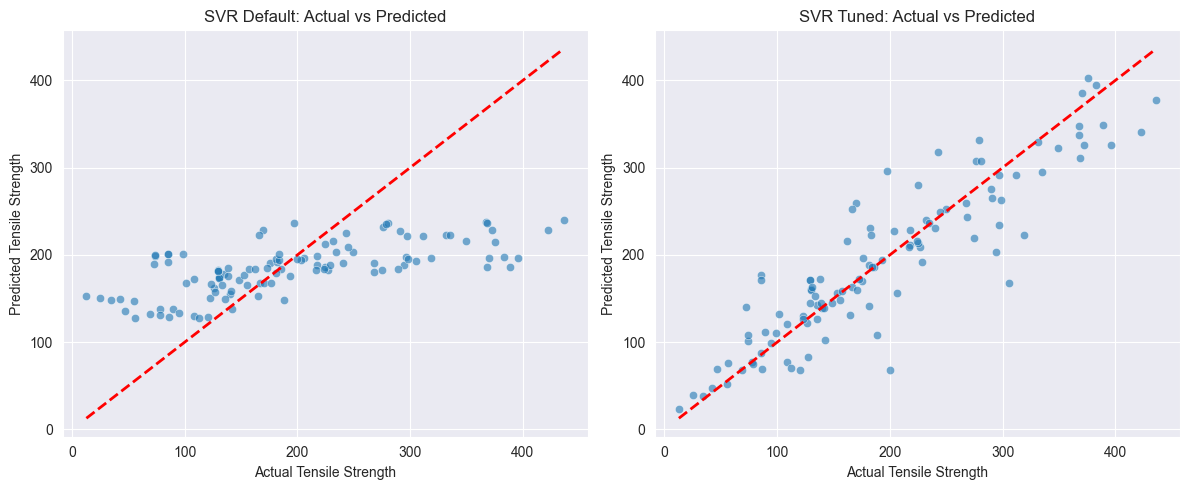

In [34]:
plt.figure(figsize=(12,5))

# Default model
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=predictions_test_default, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # perfect prediction line
plt.xlabel("Actual Tensile Strength")
plt.ylabel("Predicted Tensile Strength")
plt.title("SVR Default: Actual vs Predicted")

# Tuned model
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Tensile Strength")
plt.ylabel("Predicted Tensile Strength")
plt.title("SVR Tuned: Actual vs Predicted")

plt.tight_layout()
plt.show()

preduction errors

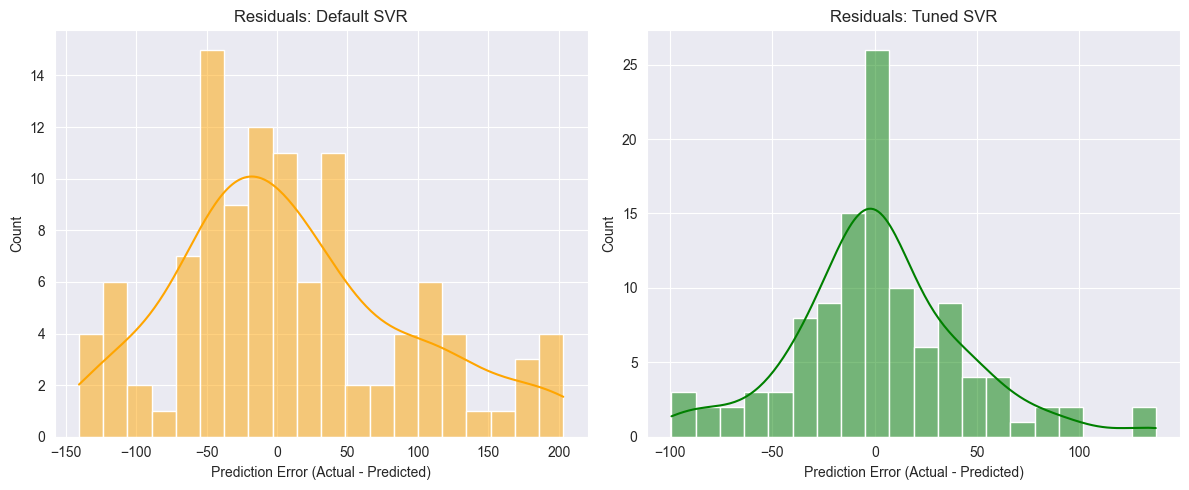

In [35]:
residuals_default = y_test - predictions_test_default
residuals_tuned = y_test - test_pred

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(residuals_default, kde=True, bins=20, color='orange')
plt.title("Residuals: Default SVR")
plt.xlabel("Prediction Error (Actual - Predicted)")

plt.subplot(1, 2, 2)
sns.histplot(residuals_tuned, kde=True, bins=20, color='green')
plt.title("Residuals: Tuned SVR")
plt.xlabel("Prediction Error (Actual - Predicted)")

plt.tight_layout()
plt.show()

Hyperparameter effect

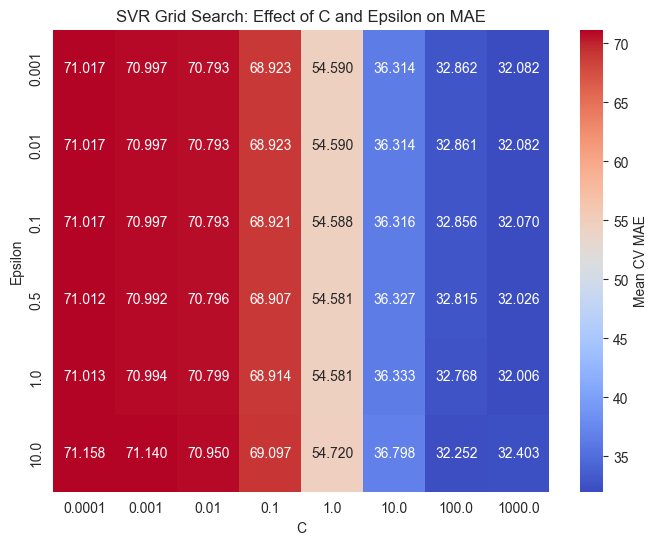

In [38]:
results = grid_search.cv_results_
df_results = pd.DataFrame(results)

# Extract relevant data
pivot_table = df_results.pivot_table(
    values='mean_test_score',
    index='param_epsilon',
    columns='param_C'
)

# Convert to positive MAE
pivot_table = -pivot_table

plt.figure(figsize=(8,6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'Mean CV MAE'})
plt.title("SVR Grid Search: Effect of C and Epsilon on MAE")
plt.xlabel("C")
plt.ylabel("Epsilon")
plt.show()